In [185]:
%load_ext rpy2.ipython
import rpy2.robjects.lib.ggplot2 as ggplot2
import childespy
import numpy as np
import os
import imp
import pandas as pd
import transformers
import torch
import scipy.stats
import copy
from string import punctuation

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
#how many single-xxx, multi-xxx, and no-xxx child utterances are in English PhonBank? 
# how many tokens does the first case correspond to
# of these, how many are monosyllabic phono vs. multi-syllabic phono

In [38]:
phono_glosses = childespy.get_sql_query('select gloss, target_child_name, target_child_age, \
    speaker_code, actual_phonology, model_phonology, transcript_id, utterance_id, \
    token_order, corpus_name, collection_name, language from token where \
    actual_phonology != "" and model_phonology != "" and collection_name = "Eng-NA"' ,
        db_version = "2020.1")

R[write to console]: Using supported database version: '2020.1'.



In [156]:
phono_glosses.loc[phono_glosses.gloss == 'xxx'].actual_phonology.value_counts()

*       26786
ə          10
(.)         8
aɪ          4
ən          2
        ...  
əno         1
wɛ          1
iəɪs        1
tʃid        1
faɪ         1
Name: actual_phonology, Length: 77, dtype: int64

Actual phonology is almost always * for xxx items

In [157]:
phono_glosses.loc[phono_glosses.gloss == 'yyy'].actual_phonology.value_counts()

ɛ         3207
ʌ         2154
ɪ         1881
o          514
ə          513
          ... 
dowɑno       1
ɪstæwo       1
dɪhʊ         1
dʊ^də        1
wʌtɪs        1
Name: actual_phonology, Length: 30476, dtype: int64

Actual phonology is populated for yyy items

In [68]:
chi_phono = phono_glosses.loc[(phono_glosses.speaker_code == 'CHI') & 
    (phono_glosses.target_child_age < (365*5))]

In [69]:
def count_transmission_errors(utt_vector, error_codes):
    return(np.sum([x in error_codes for x in  utt_vector]))

In [159]:
xxxs_per_utt = chi_phono.groupby('utterance_id').gloss.agg(
    lambda x: count_transmission_errors(x, ['xxx'])).reset_index()
xxxs_per_utt.columns = ['utterance_id', 'num_xxx']
yyys_per_utt = chi_phono.groupby('utterance_id').gloss.agg(
    lambda x: count_transmission_errors(x, ['yyy'])).reset_index()
yyys_per_utt.columns = ['utterance_id', 'num_yyy']
failures_per_utt = xxxs_per_utt.merge(yyys_per_utt)

In [166]:
yyy_utts = failures_per_utt.loc[(failures_per_utt.num_xxx == 0) &  (failures_per_utt.num_yyy == 1)]

In [167]:
yyy_utts.shape

(31760, 3)

In [168]:
success_utts = failures_per_utt.loc[(failures_per_utt.num_xxx == 0) &  
    (failures_per_utt.num_yyy == 0)]

In [175]:
success_utts.shape

(111812, 3)

In [169]:
tokens_from_errorless_utts = chi_phono.loc[chi_phono.utterance_id.isin(success_utts.utterance_id)]

In [170]:
excludes = ['*','(.)','(..)', '(...)','(....)','(.....)']
tokens_from_errorless_utts = tokens_from_errorless_utts.loc[~(tokens_from_errorless_utts.actual_phonology.isin(excludes) |
    tokens_from_errorless_utts.model_phonology.isin(excludes))]

In [173]:
tokens_from_errorless_utts.shape

(271272, 13)

In [174]:
tokens_from_errorless_utts.actual_phonology

103469            ə
103470           ðæ
103471           aj
103472           aj
103473           aj
            ...    
458551        θʊtin
458552    fɜ˞rzdeɪː
458553     fɜ˞rsdeɪ
458554     hɜ˞rzdeɪ
458555         fʌ̃m
Name: actual_phonology, Length: 271272, dtype: object

In [ ]:
# 31,760 transmission errors (from 31,760 utterances)
# 271,272 transmission successes (from 111,812 utterances)

# Prevalence of communication failures by age 

In [91]:
error_codes = ('xxx','yyy','zzz')

In [108]:
chi_phono['target_child_age_months'] = chi_phono.target_child_age / 30.5

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [142]:
error_prop_per_transcript = chi_phono.groupby('transcript_id').gloss.agg(lambda x:
        sum(np.array([y in error_codes for y in x]) / len(x))).reset_index()
error_prop_per_transcript.columns = ['transcript_id', 'proportion_errors']
age_per_transcript = chi_phono.groupby('transcript_id').target_child_age_months.agg(np.unique).reset_index()                    
tokens_per_transcript = chi_phono.groupby('transcript_id').target_child_age_months.agg(np.size).reset_index()                    
tokens_per_transcript.columns = ['transcript_id', 'num_tokens']
corpusname_for_transcript = chi_phono.groupby('transcript_id').corpus_name.agg(np.unique).reset_index()
error_prop_per_transcript = error_prop_per_transcript.merge(age_per_transcript).merge(
    tokens_per_transcript).merge(corpusname_for_transcript)
error_prop_per_transcript.head(5)
%R -i error_prop_per_transcript

In [143]:
error_prop_per_transcript.columns

Index(['transcript_id', 'proportion_errors', 'target_child_age_months',
       'num_tokens', 'corpus_name'],
      dtype='object')

R[write to console]: `geom_smooth()` using method = 'loess' and formula 'y ~ x'



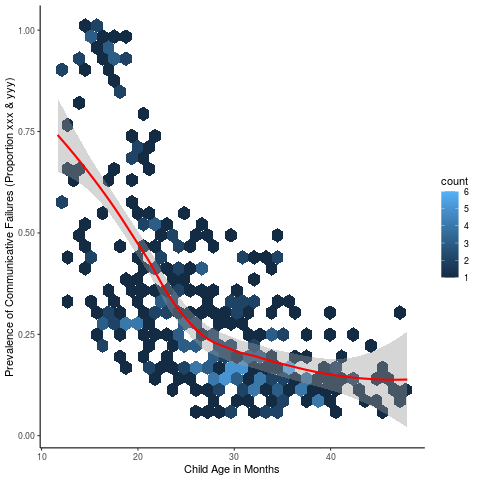

In [177]:
%%R 
ggplot(subset(error_prop_per_transcript,target_child_age_months < 48
    & num_tokens > 20 & corpus_name == 'Providence')) + geom_hex(aes(x=target_child_age_months, 
y=proportion_errors)) + theme_classic() + xlab('Child Age in Months') + ylab(
'Prevalence of Communicative Failures (Proportion xxx & yyy)') + stat_smooth(
aes(x=target_child_age_months,  y=proportion_errors), color= 'red')

In [130]:
## why are there 0-prop ones so early? What are these transcripts?
error_prop_per_transcript.loc[(error_prop_per_transcript.target_child_age_months < 20)
    & (error_prop_per_transcript.proportion_errors == 0) & (error_prop_per_transcript.num_tokens
    > 20 )]

,transcript_id,proportion_errors,target_child_age_months,num_tokens
61,41294,0.0,19.991803,23.0
714,42662,0.0,19.452869,42.0
716,42664,0.0,19.518443,25.0
718,42666,0.0,19.584016,23.0
725,42673,0.0,19.780738,23.0
726,42674,0.0,19.959016,26.0
1068,43017,0.0,17.883197,21.0
1073,43022,0.0,18.225410,23.0
1088,43037,0.0,19.551230,35.0
1415,43369,0.0,15.526639,33.0


In [132]:
chi_phono.loc[chi_phono.transcript_id == 41294]

,gloss,target_child_name,target_child_age,speaker_code,actual_phonology,model_phonology,transcript_id,utterance_id,token_order,corpus_name,collection_name,language,target_child_age_months
119198,bike,E,609.75,CHI,bakʰ,baɪk,41294,16647109,1,Inkelas,Eng-NA,eng,19.991803
120983,bee,E,609.75,CHI,biː,biː,41294,16647219,1,Inkelas,Eng-NA,eng,19.991803
138605,bus,E,609.75,CHI,bʌʂ,bʌs,41294,16647048,1,Inkelas,Eng-NA,eng,19.991803
154932,duck,E,609.75,CHI,kʰʌk,dʌk,41294,16647271,1,Inkelas,Eng-NA,eng,19.991803
163119,foot,E,609.75,CHI,fʊtʰ,fʊt,41294,16647129,1,Inkelas,Eng-NA,eng,19.991803
178427,helmet,E,609.75,CHI,hɛmi,hɛlmət,41294,16647099,1,Inkelas,Eng-NA,eng,19.991803
179090,Henry,E,609.75,CHI,hɛni,hɛnɹiː,41294,16647066,1,Inkelas,Eng-NA,eng,19.991803
202640,yuck,E,609.75,CHI,jʌkʰ,jʌk,41294,16647075,1,Inkelas,Eng-NA,eng,19.991803
202641,yuck,E,609.75,CHI,ʌkʰ,jʌk,41294,16647089,1,Inkelas,Eng-NA,eng,19.991803
210371,caboose,E,609.75,CHI,ʌbuəʂ,kəbuːs,41294,16647023,1,Inkelas,Eng-NA,eng,19.991803


In [136]:
error_prop_per_transcript.loc[(error_prop_per_transcript.target_child_age_months < 24)
    & (error_prop_per_transcript.proportion_errors > .95) &  (error_prop_per_transcript.num_tokens > 20)]

,transcript_id,proportion_errors,target_child_age_months,num_tokens
264,42205,0.957921,17.358607,404.0
266,42207,0.984102,18.422131,629.0
368,42309,0.987281,14.889344,629.0
369,42310,0.964765,15.723361,596.0
370,42311,0.972868,15.395492,774.0
371,42312,0.995136,15.821721,1028.0
533,42474,1.000000,14.430328,187.0
534,42475,1.000000,15.264344,278.0
535,42476,0.996466,15.821721,283.0
536,42477,1.000000,16.196721,72.0


In [137]:
chi_phono.loc[chi_phono.transcript_id == 42205]

,gloss,target_child_name,target_child_age,speaker_code,actual_phonology,model_phonology,transcript_id,utterance_id,token_order,corpus_name,collection_name,language,target_child_age_months
389,yyy,Alex,529.4375,CHI,ʌ̃,*,42205,16759608,1,Providence,Eng-NA,eng,17.358607
390,yyy,Alex,529.4375,CHI,ɡæpɪð,*,42205,16759608,2,Providence,Eng-NA,eng,17.358607
391,yyy,Alex,529.4375,CHI,ʌ,*,42205,16759643,1,Providence,Eng-NA,eng,17.358607
392,yyy,Alex,529.4375,CHI,ɪ,*,42205,16759643,2,Providence,Eng-NA,eng,17.358607
393,yyy,Alex,529.4375,CHI,ɪ,*,42205,16759643,3,Providence,Eng-NA,eng,17.358607
...,...,...,...,...,...,...,...,...,...,...,...,...,...
319216,wee,Alex,529.4375,CHI,wiːɪ,wiː,42205,16760372,1,Providence,Eng-NA,eng,17.358607
319217,wee,Alex,529.4375,CHI,wiː,wiː,42205,16763775,1,Providence,Eng-NA,eng,17.358607
319218,wee,Alex,529.4375,CHI,wiː,wiː,42205,16764496,1,Providence,Eng-NA,eng,17.358607
329275,water,Alex,529.4375,CHI,ʌːdɜ˞,wɑtəɹ,42205,16764283,1,Providence,Eng-NA,eng,17.358607


### Test for monosyllabicity

In [ ]:
# 2 options: 
# 1. look for 2 or more sections of Vs separate by Cs; alternatively, 
    # this requires dealing with this long tail of rare IPA; maybe figure out how to map from IPA
    # to CMU citation forms
# 2. Look the gloss up in a syllabified dictionary (this already reflects the )

In [150]:
tokens_from_pvd = chi_phono.loc[(chi_phono.transcript_id.isin(error_prop_per_transcript.loc
    [error_prop_per_transcript.corpus_name == "Providence"].transcript_id))]

In [151]:
tokens_from_pvd.shape

(396621, 13)

In [178]:
# get the phoneme inventory from actual phonology and 
ipa_chars = set(list(
    ' '.join(np.unique(tokens_from_errorless_utts.model_phonology)) +
    ' '.join(np.unique(tokens_from_errorless_utts.actual_phonology))
))
print(' '.join(ipa_chars))

. ɖ ɞ v ɱ ç ˞ ʊ ̰ ɬ ɶ ̚ ^ y V ŋ ʰ k ̞ ɐ ʷ ɦ ʍ ʉ ʦ ː ʤ ʒ ̘ h ɮ ɒ b l e ̆ w ʀ ɟ ɚ c ʑ q ð ̟ ɥ ͡ ɾ œ ˀ ̺ ̬ ɘ ɣ ʏ ɢ ̜ ɪ ɝ ̩ z ̵ ʣ g ʧ ɸ β j ʂ ɡ ɰ ˠ ɵ ʝ ̥ p u ʴ ʃ ̪ ɑ o d m ̯ ̣ ʌ ̤ ɻ n ʲ ʎ ˑ ̙ ɨ ɹ ˺ ́ ̹ ɫ a r ɲ ʙ ɜ ̠ ɯ ʁ ̂ t   ʈ θ f ɤ ̃ x χ ø ʔ ɕ i ̽ æ s ɛ ɔ ə ʋ


In [154]:
pvd_phoneme_prevalence = pd.Series(list(
    ' '.join(np.unique(tokens_from_pvd.model_phonology)) +
    ' '.join(np.unique(tokens_from_pvd.actual_phonology))
)).value_counts().reset_index()

,index,0
0,,71684
1,ɪ,33576
2,ə,24892
3,d,18894
4,i,18183
...,...,...
61,),2
62,ɱ,2
63,x,2
64,ɚ,1


In [ ]:
# Need to remap from the Phonbank phonology to a simplified phonology where I can use the PFST
# Simplified phonology will also make it easier to distinguish between consonants and vowels
# Want to measure the coverage of the model-based phonology and the actual phonology
# okay to throw away some data in this process


# Masked Language Prediction Softmax with BERT 

In [180]:
from pytorch_pretrained_bert import BertForMaskedLM

In [790]:
from transformers import BertTokenizer

In [228]:
import transfomers_bert_completions
imp.reload(transfomers_bert_completions)

<module 'transfomers_bert_completions' from '/home/stephan/notebooks/child-directed-listening/transfomers_bert_completions.py'>

In [342]:
bertMaskedLM = BertForMaskedLM.from_pretrained('bert-base-uncased')
bertMaskedLM.eval()
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [229]:
transfomers_bert_completions.compare_completions("mommy [MASK] .", bertMaskedLM, tokenizer).head(10)

,prob,word,rank
999,0.043639,!,0
5222,0.018040,wins,1
8658,0.016046,feat,2
2293,0.013641,love,3
5285,0.011568,vol,4
5443,0.011388,vs,5
3336,0.011358,baby,6
2611,0.010932,girl,7
2879,0.006419,boy,8
10955,0.005327,sings,9


In [230]:
transfomers_bert_completions.compare_completions("where [MASK] ?", bertMaskedLM, tokenizer).head(10)

,prob,word,rank
2000,0.454888,to,0
2842,0.237073,else,1
2085,0.097786,now,2
2133,0.063521,...,3
2059,0.011167,then,4
1029,0.008017,?,5
3599,0.007931,exactly,6
2003,0.007056,is,7
2013,0.006340,from,8
1999,0.006288,in,9


In [231]:
transfomers_bert_completions.compare_completions("hi [MASK] .", bertMaskedLM, tokenizer).head(10)

,prob,word,rank
3217,0.034561,##ro,0
2721,0.027147,##la,1
2278,0.025326,##c,2
3600,0.023967,##ck,3
3630,0.022182,##no,4
3070,0.022060,##ng,5
17364,0.021378,##jack,6
3597,0.021141,##co,7
2527,0.020253,##ra,8
2140,0.019197,##l,9


In [232]:
transfomers_bert_completions.compare_completions("what [MASK] .", bertMaskedLM, tokenizer).head(10)

,prob,word,rank
2065,0.521930,if,0
3047,0.042963,happened,1
1996,0.039804,the,2
1029,0.026004,?,3
2085,0.018232,now,4
2720,0.017595,mr,5
1037,0.013899,a,6
2005,0.011796,for,7
2055,0.008336,about,8
2785,0.008206,kind,9


In [252]:
completions = transfomers_bert_completions.compare_completions("go [MASK] .", bertMaskedLM, tokenizer)

In [253]:
completions

,prob,word,rank
2006,1.638184e-01,on,0
3805,1.473298e-01,ahead,1
2185,1.082801e-01,away,2
2188,9.947739e-02,home,3
4095,3.158719e-02,##sh,4
...,...,...,...
27484,1.254488e-09,##pressive,30517
22934,1.206291e-09,##rigues,30518
28739,1.161330e-09,##ivar,30519
21525,1.075385e-09,##grove,30520


# Run Actual Sents Through BERT for Prediction

In [289]:
pvd_idx = childespy.get_sql_query('select * from corpus where name = "Providence"').iloc[0]['id']

R[write to console]: Using current database version: '2020.1'.



In [776]:
regenerate = True

if regenerate:
    utt_glosses = childespy.get_sql_query('select gloss, transcript_id, id, \
    utterance_order, speaker_code, type from utterance where corpus_id = '+str(pvd_idx) ,
        db_version = "2020.1")
    utt_glosses.to_csv('csv/pvd_utt_glosses.csv', index=False)
else: 
    utt_glosses = pd.read_csv('csv/pvd_utt_glosses.csv')

R[write to console]: Using supported database version: '2020.1'.



In [779]:
def fix_gloss(gloss):
    return(str(gloss).replace('+',' ').replace('_',' '))

utt_glosses.gloss = [fix_gloss(x) for x in utt_glosses.gloss]

punct_for_type = {
    'question':'?',
    'declarative':'.',
    'interruption':'!',
    'trail off':'...',
    'trail off question':'?',
    'imperative_emphatic':'!' 
}

utt_glosses['punct'] = [punct_for_type[x] if x in punct_for_type else None
                        for x in utt_glosses.type ]

utt_glosses = utt_glosses.loc[[x is not None for x in utt_glosses.punct]]
utt_glosses['speaker_code_simple'] = ['[CHI]' if x == 'CHI' else '[CGV]'
    for x in utt_glosses.speaker_code]

utt_glosses['gloss_with_punct'] = [x['speaker_code_simple'] +' '+ x['gloss'].lower().replace('yyy','@').replace('xxx','$')+ x['punct'] for x in utt_glosses.to_dict('records')] 
utt_glosses.shape

(452268, 9)

In [780]:
utt_glosses

,gloss,transcript_id,id,utterance_order,speaker_code,type,punct,speaker_code_simple,gloss_with_punct
1,where do you want me to go,42204,16759250,1,OPE,question,?,[CGV],[CGV] where do you want me to go?
2,anywhere you'll feel comfortable um anywhere,42204,16759261,2,MOT,declarative,.,[CGV],[CGV] anywhere you'll feel comfortable um anyw...
3,please don't do that,42204,16759270,3,MOT,declarative,.,[CGV],[CGV] please don't do that.
6,Mommy,42204,16759315,6,CHI,declarative,.,[CHI],[CHI] mommy.
7,okay that's fine,42204,16759322,7,MOT,declarative,.,[CGV],[CGV] okay that's fine.
...,...,...,...,...,...,...,...,...,...
460056,nobody hates Simba,42569,17280946,755,CHI,declarative,.,[CHI],[CHI] nobody hates simba.
460058,hippo,42569,17280992,757,CHI,declarative,.,[CHI],[CHI] hippo.
460059,xxx,42569,17281011,758,FAT,declarative,.,[CGV],[CGV] $.
460060,xxx la la xxx,42569,17281030,759,CHI,declarative,.,[CHI],[CHI] $ la la $.


In [791]:
### need the tokenizer corresponding to the model; note this has to come from 
# transformers, not masked language model scoring library, which will not include
# the additional defined types (yyy and xxx)
tokenizer = BertTokenizer.from_pretrained('model_output2')

In [793]:
# this is slow, because tokenization is slow
def inflate (row):
    tokens = tokenizer.tokenize(row['gloss_with_punct'])
    return(pd.DataFrame({'token':tokens, 'id':row['id']}) )

regenerate = True
if regenerate:
    all_tokens = pd.concat([inflate(x) for x in utt_glosses.to_dict('records')])
    all_tokens = all_tokens.merge(utt_glosses)
    all_tokens.to_csv('csv/pvd_utt_glosses_inflated.csv')

else:
    all_tokens = pd.read_csv('csv/pvd_utt_glosses_inflated.csv', na_filter=False)

In [794]:
all_tokens.iloc[1]

token                                              where
id                                              16759250
gloss                         where do you want me to go
transcript_id                                      42204
utterance_order                                        1
speaker_code                                         OPE
type                                            question
punct                                                  ?
speaker_code_simple                                [CGV]
gloss_with_punct       [CGV] where do you want me to go?
Name: 1, dtype: object

In [797]:
all_tokens['token_id'] = tokenizer.convert_tokens_to_ids(all_tokens['token'])
all_tokens['seq_utt_id'] = all_tokens['id'].astype('category').cat.codes

In [796]:
all_tokens.loc[all_tokens.gloss_with_punct == "[CHI] what is this @."]

,token,id,gloss,transcript_id,utterance_order,speaker_code,type,punct,speaker_code_simple,gloss_with_punct
26357,[chi],16764425,what is this yyy,42211,343,CHI,declarative,.,[CHI],[CHI] what is this @.
26358,what,16764425,what is this yyy,42211,343,CHI,declarative,.,[CHI],[CHI] what is this @.
26359,is,16764425,what is this yyy,42211,343,CHI,declarative,.,[CHI],[CHI] what is this @.
26360,this,16764425,what is this yyy,42211,343,CHI,declarative,.,[CHI],[CHI] what is this @.
26361,@,16764425,what is this yyy,42211,343,CHI,declarative,.,[CHI],[CHI] what is this @.
26362,.,16764425,what is this yyy,42211,343,CHI,declarative,.,[CHI],[CHI] what is this @.
31313,[chi],16765341,what is this yyy,42211,396,CHI,declarative,.,[CHI],[CHI] what is this @.
31314,what,16765341,what is this yyy,42211,396,CHI,declarative,.,[CHI],[CHI] what is this @.
31315,is,16765341,what is this yyy,42211,396,CHI,declarative,.,[CHI],[CHI] what is this @.
31316,this,16765341,what is this yyy,42211,396,CHI,declarative,.,[CHI],[CHI] what is this @.


In [799]:
utt_df = all_tokens.loc[all_tokens.id == 16764425] # 16764425 is a good test example
utt_df

,token,id,gloss,transcript_id,utterance_order,speaker_code,type,punct,speaker_code_simple,gloss_with_punct,token_id,seq_utt_id
26357,[chi],16764425,what is this yyy,42211,343,CHI,declarative,.,[CHI],[CHI] what is this @.,30522,4567
26358,what,16764425,what is this yyy,42211,343,CHI,declarative,.,[CHI],[CHI] what is this @.,2054,4567
26359,is,16764425,what is this yyy,42211,343,CHI,declarative,.,[CHI],[CHI] what is this @.,2003,4567
26360,this,16764425,what is this yyy,42211,343,CHI,declarative,.,[CHI],[CHI] what is this @.,2023,4567
26361,@,16764425,what is this yyy,42211,343,CHI,declarative,.,[CHI],[CHI] what is this @.,1030,4567
26362,.,16764425,what is this yyy,42211,343,CHI,declarative,.,[CHI],[CHI] what is this @.,1012,4567


In [800]:
adult_bertMaskedLM = BertForMaskedLM.from_pretrained('bert-base-uncased')
adult_bertMaskedLM.eval()
adult_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
adult_softmax_mask = transfomers_bert_completions.get_softmax_mask(adult_tokenizer)

In [867]:
ft1_bertMaskedLM = BertForMaskedLM.from_pretrained('model_output')
ft1_bertMaskedLM.eval()
ft1_tokenizer = BertTokenizer.from_pretrained('model_output')
ft1_softmax_mask = transfomers_bert_completions.get_softmax_mask(ft1_tokenizer)

In [850]:
ft2_bertMaskedLM = BertForMaskedLM.from_pretrained('model_output2')
ft2_bertMaskedLM.eval()
ft2_tokenizer = BertTokenizer.from_pretrained('model_output2')
ft2_softmax_mask = transfomers_bert_completions.get_softmax_mask(ft2_tokenizer)

In [851]:
' '.join(all_tokens.loc[all_tokens.id == 16759270].token)

"[cgv] please don ' t do that ."

# BERT without Context

In [1135]:
import transfomers_bert_completions
imp.reload(transfomers_bert_completions)

<module 'transfomers_bert_completions' from '/home/stephan/notebooks/child-directed-listening/transfomers_bert_completions.py'>

In [1125]:
# otsb: off the shelf BERT
transfomers_bert_completions.bert_completions(
    "[MASK] .", adult_bertMaskedLM, adult_tokenizer, adult_softmax_mask).head(10)

['[CLS]', '[MASK]', '.', '[SEP]']


,prob,word,rank
25,0.086128,p,0
4000,0.057330,vol,1
7115,0.048580,math,2
21836,0.043764,soc,3
7391,0.031506,trans,4
2787,0.024802,ed,5
5626,0.016628,bull,6
1399,0.012529,ii,7
13728,0.011427,sci,8
1334,0.009822,art,9


In [1136]:
# no context, otsb: off the shelf BERT
transfomers_bert_completions.get_stats_for_failure(
    all_tokens, 16764425, adult_bertMaskedLM, adult_tokenizer, adult_softmax_mask,
    None, use_speaker_labels=False)

16764425


/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,rank,prob,entropy,num_tokens_in_context
0,None,None,6.573516,4


In [1138]:
# no context, otsb: off the shelf BERT
transfomers_bert_completions.get_stats_for_success(all_tokens, 16759270, adult_bertMaskedLM, 
        adult_tokenizer, adult_softmax_mask, 'score', None, use_speaker_labels=False)

,rank,prob,entropy,num_tokens_in_context,mask_position,token,utterance_id
0,None,None,2.908155,6,0,please,16759270
0,None,None,0.026201,6,1,don,16759270
0,None,None,2.428116,6,2,',16759270
0,None,None,0.000199,6,3,t,16759270
0,None,None,0.972307,6,4,do,16759270
0,None,None,0.444166,6,5,that,16759270


In [1140]:
# Fine-tuned BERT: don't use speaker labels
transfomers_bert_completions.bert_completions(
    "[MASK] .", ft1_bertMaskedLM, ft1_tokenizer, adult_softmax_mask).head(10)

['[CLS]', '[MASK]', '.', '[SEP]']


,prob,word,rank
965,0.015430,the,0
1020,0.011551,no,1
10,0.010107,a,2
978,0.009077,it,3
975,0.008506,on,4
967,0.007841,and,5
971,0.007624,he,6
996,0.007452,one,7
977,0.007437,that,8
1016,0.006916,two,9


In [1143]:
# no context ft1: Fine-tuned BERT: don't use speaker labels
transfomers_bert_completions.get_stats_for_failure(
    all_tokens, 16764425, ft1_bertMaskedLM, ft1_tokenizer, ft1_softmax_mask,
    None, use_speaker_labels=False)

16764425


/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,rank,prob,entropy,num_tokens_in_context
0,None,None,7.943211,4


In [1144]:
# no context, ft1: Fine-tuned BERT: don't use speaker labels
transfomers_bert_completions.get_stats_for_success(all_tokens, 16759270, ft1_bertMaskedLM, 
        ft1_tokenizer, ft1_softmax_mask, 'score', None, use_speaker_labels=False)

,rank,prob,entropy,num_tokens_in_context,mask_position,token,utterance_id
0,None,None,5.871956,6,0,please,16759270
0,None,None,0.024977,6,1,don,16759270
0,None,None,4.342630,6,2,',16759270
0,None,None,0.000013,6,3,t,16759270
0,None,None,1.146747,6,4,do,16759270
0,None,None,0.694078,6,5,that,16759270


In [1146]:
# ft2: Fine-tuned BERT: with speaker labels
transfomers_bert_completions.bert_completions(
    "[chi] [MASK] .", ft2_bertMaskedLM, ft2_tokenizer, ft2_softmax_mask).head(10)

['[CLS]', '[chi]', '[MASK]', '.', '[SEP]']


,prob,word,rank
2070,0.069231,foundation,0
2765,0.048574,grant,1
5115,0.029757,blake,2
6428,0.019742,yale,3
11088,0.019432,albion,4
2315,0.013228,beyond,5
1130,0.012394,group,6
6349,0.012294,arch,7
2078,0.012078,property,8
8152,0.011486,morrison,9


In [1148]:
# no context ft2: Fine-tuned BERT: with speaker labels
transfomers_bert_completions.get_stats_for_failure(
    all_tokens, 16764425, ft2_bertMaskedLM, ft2_tokenizer,
    ft2_softmax_mask, None, use_speaker_labels=True,
    preserve_errors=True)

16764425


/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,rank,prob,entropy,num_tokens_in_context
0,None,None,9.126583,5


In [1149]:
transfomers_bert_completions.get_stats_for_success(all_tokens, 16759270, 
    ft2_bertMaskedLM, ft2_tokenizer, ft2_softmax_mask, 'score', None, use_speaker_labels=True)

,rank,prob,entropy,num_tokens_in_context,mask_position,token,utterance_id
0,None,None,5.675140,7,0,[cgv],16759270
0,None,None,7.871069,7,1,please,16759270
0,None,None,0.047818,7,2,don,16759270
0,None,None,4.081160,7,3,',16759270
0,None,None,0.000002,7,4,t,16759270
0,None,None,1.422518,7,5,do,16759270
0,None,None,0.654516,7,6,that,16759270


# BERT with Context

### Entropy with Manual Model Feeding

In [990]:
df = transfomers_bert_completions.bert_completions(
    "look ! [SEP] you see the ball . [SEP] what is it? [SEP] [MASK] !",
    adult_bertMaskedLM,
    adult_tokenizer
)
print(df)
print(scipy.stats.entropy(df['prob']))

['[CLS]', 'look', '!', '[SEP]', 'you', 'see', 'the', 'ball', '.', '[SEP]', 'what', 'is', 'it', '?', '[SEP]', '[MASK]', '!', '[SEP]']
               prob    word   rank
2298   9.283391e-01    look      0
2156   1.706982e-02     see      1
999    5.096575e-03       !      2
4931   3.904463e-03     hey      3
3524   3.231433e-03    wait      4
...             ...     ...    ...
20360  2.886496e-11  ##mour  30517
29180  1.917664e-11  ##oric  30518
27869  1.874292e-11  ##anor  30519
15603  1.659796e-11   ##rew  30520
27416  1.632611e-11  ##orio  30521

[30522 rows x 3 columns]
0.6011372


In [992]:
df = transfomers_bert_completions.bert_completions(
    "[MASK] !",
    adult_bertMaskedLM,
    adult_tokenizer
)
print(df)
print(scipy.stats.entropy(df['prob']))

['[CLS]', '[MASK]', '!', '[SEP]']
               prob       word   rank
999    1.101744e-01          !      0
2821   6.321181e-02         oh      1
2175   2.329776e-02         go      2
9748   2.107618e-02       bang      3
8797   2.092811e-02       boom      4
...             ...        ...    ...
27610  7.246090e-09     ##lynn  30517
15830  6.975518e-09    ##inian  30518
19791  6.255987e-09     ##gill  30519
25523  5.502009e-09  ##ference  30520
28207  3.310612e-09     ##gnan  30521

[30522 rows x 3 columns]
6.6244926


In [993]:
df = transfomers_bert_completions.bert_completions(
    "look ! [SEP] you see the ball . [SEP] what is it? [SEP] [MASK] !",
    ft1_bertMaskedLM,
    ft1_tokenizer
)
print(df)
print(scipy.stats.entropy(df['prob']))

['[CLS]', 'look', '!', '[SEP]', 'you', 'see', 'the', 'ball', '.', '[SEP]', 'what', 'is', 'it', '?', '[SEP]', '[MASK]', '!', '[SEP]']
               prob       word   rank
2298   8.190757e-01       look      0
3608   6.899779e-02       ball      1
2821   1.053964e-02         oh      2
3422   8.294668e-03      watch      3
2156   4.918193e-03        see      4
...             ...        ...    ...
27109  3.448186e-12    ##nosis  30517
28533  2.764060e-12     ##rest  30518
20360  2.739691e-12     ##mour  30519
24773  2.136642e-12  eastbound  30520
28528  1.967361e-12     moffat  30521

[30522 rows x 3 columns]
1.1378466


In [994]:
df = transfomers_bert_completions.bert_completions(
    "[MASK] !",
    ft1_bertMaskedLM,
    ft1_tokenizer
)
print(df)
print(scipy.stats.entropy(df['prob']))

['[CLS]', '[MASK]', '!', '[SEP]']
               prob     word   rank
2175   5.030006e-02       go      0
2821   4.229978e-02       oh      1
2053   2.769081e-02       no      2
6289   2.503083e-02       ah      3
8797   2.343523e-02     boom      4
...             ...      ...    ...
29110  1.890575e-09  ##enter  30517
20086  1.627345e-09  ##hetic  30518
25686  1.579053e-09   scully  30519
26154  1.442617e-09   ##zard  30520
28528  1.192801e-09   moffat  30521

[30522 rows x 3 columns]
6.228609


In [988]:
df = transfomers_bert_completions.bert_completions(
    "[cgv] look ! [cgv] [SEP] you see the ball . [SEP] [cgv] what is it? [SEP] [cgv] [MASK] !",
    ft2_bertMaskedLM,
    ft2_tokenizer
)
print(df)
print(scipy.stats.entropy(df['prob']))

['[CLS]', '[cgv]', 'look', '!', '[cgv]', '[SEP]', 'you', 'see', 'the', 'ball', '.', '[SEP]', '[cgv]', 'what', 'is', 'it', '?', '[SEP]', '[cgv]', '[MASK]', '!', '[SEP]']
               prob      word   rank
2298   7.075326e-01      look      0
3608   5.044350e-02      ball      1
2156   1.658710e-02       see      2
2053   1.219264e-02        no      3
2360   9.544699e-03       say      4
...             ...       ...    ...
20159  1.331875e-10    ##llus  30519
18314  1.165713e-10       edo  30520
12581  9.135695e-11  sexually  30521
26646  4.778686e-11   epstein  30522
20360  3.433847e-11    ##mour  30523

[30524 rows x 3 columns]
2.0987604


Entropy constrains just fine with manual model feeding direct to BERT completions

### Comparison of model Completions

In [1152]:
full_context = "you can play it . [SEP] build the blocks . [SEP] look . [SEP] what is this [MASK] . [SEP] wee . [SEP] what ? [SEP] alright just a little . . ."
minimal_context = "what is this [MASK] ."

In [1153]:
df1 = transfomers_bert_completions.bert_completions(full_context, adult_bertMaskedLM,
    adult_tokenizer, adult_softmax_mask)
print(scipy.stats.entropy(df1.prob, base=2))
df1.head(10)

['[CLS]', 'you', 'can', 'play', 'it', '.', '[SEP]', 'build', 'the', 'blocks', '.', '[SEP]', 'look', '.', '[SEP]', 'what', 'is', 'this', '[MASK]', '.', '[SEP]', 'wee', '.', '[SEP]', 'what', '?', '[SEP]', 'alright', 'just', 'a', 'little', '.', '.', '.', '[SEP]']
7.305902808602111


,prob,word,rank
974,0.113245,for,0
1022,0.084794,about,1
1126,0.080767,place,2
1449,0.065823,thing,3
1082,0.040511,way,4
2005,0.033735,guy,5
3671,0.026487,stuff,6
1018,0.026292,time,7
1161,0.026129,game,8
12143,0.017441,nonsense,9


In [1154]:
df2 = transfomers_bert_completions.bert_completions(minimal_context, adult_bertMaskedLM,
    adult_tokenizer, adult_softmax_mask)
print(scipy.stats.entropy(df2.prob, base=2))
df2.head(10)

['[CLS]', 'what', 'is', 'this', '[MASK]', '.', '[SEP]']
6.573516065764047


,prob,word,rank
1126,0.309615,place,0
1449,0.052994,thing,1
1111,0.045551,man,2
1018,0.037300,time,3
1022,0.034903,about,4
2005,0.024883,guy,5
974,0.017813,for,6
1387,0.013451,woman,7
12143,0.012375,nonsense,8
1050,0.010641,world,9


In [1155]:
df1 = transfomers_bert_completions.bert_completions(full_context, ft1_bertMaskedLM,
    ft1_tokenizer, ft1_softmax_mask)
print(scipy.stats.entropy(df1.prob, base=2))
df1.head(10)

['[CLS]', 'you', 'can', 'play', 'it', '.', '[SEP]', 'build', 'the', 'blocks', '.', '[SEP]', 'look', '.', '[SEP]', 'what', 'is', 'this', '[MASK]', '.', '[SEP]', 'wee', '.', '[SEP]', 'what', '?', '[SEP]', 'alright', 'just', 'a', 'little', '.', '.', '.', '[SEP]']
6.999964934774072


,prob,word,rank
1449,0.129961,thing,0
996,0.124322,one,1
1135,0.045119,here,2
7694,0.039097,fraser,3
1123,0.035687,called,4
974,0.028111,for,5
10710,0.019077,mum,6
1242,0.018339,look,7
5422,0.015250,honey,8
1013,0.014492,there,9


In [1156]:
df2 = transfomers_bert_completions.bert_completions(minimal_context, ft1_bertMaskedLM,
    ft1_tokenizer, ft1_softmax_mask)
print(scipy.stats.entropy(df2.prob, base=2))
df2.head(10)

['[CLS]', 'what', 'is', 'this', '[MASK]', '.', '[SEP]']
7.94321066273718


,prob,word,rank
996,0.093537,one,0
1449,0.079755,thing,1
972,0.050584,is,2
1135,0.042401,here,3
974,0.031132,for,4
1111,0.018116,man,5
991,0.016584,this,6
1281,0.012081,book,7
2005,0.011872,guy,8
978,0.011614,it,9


In [1158]:
# define minimal and full context with [cgv] and [chi] items
full_context = "[cgv] you can play it . [SEP] [cgv] build the blocks . [SEP] [cgv] look . [SEP] [cgv] what is this [MASK] . [SEP] [chi] wee . [SEP] [cgv] what ? [SEP] [cgv]  alright just a little . . ."
minimal_context = "[cgv] what is this [MASK] ."

In [1159]:
df1 = transfomers_bert_completions.bert_completions(minimal_context, ft2_bertMaskedLM,
    ft2_tokenizer, ft2_softmax_mask)
print(df1.head(10))
print(scipy.stats.entropy(df1.prob, base=2))

['[CLS]', '[cgv]', 'what', 'is', 'this', '[MASK]', '.', '[SEP]']
          prob    word  rank
996   0.113690     one     0
1135  0.025889    here     1
1449  0.025819   thing     2
974   0.020250     for     3
1281  0.019545    book     4
7846  0.017724     chi     5
1123  0.013560  called     6
6897  0.013428      um     7
2720  0.013301     dog     8
2918  0.009636  animal     9
8.929262872500042


In [1160]:
df2 = transfomers_bert_completions.bert_completions(full_context, ft2_bertMaskedLM,
    ft2_tokenizer, ft2_softmax_mask)
print(scipy.stats.entropy(df2.prob, base=2))
df2.head(10)

['[CLS]', '[cgv]', 'you', 'can', 'play', 'it', '.', '[SEP]', '[cgv]', 'build', 'the', 'blocks', '.', '[SEP]', '[cgv]', 'look', '.', '[SEP]', '[cgv]', 'what', 'is', 'this', '[MASK]', '.', '[SEP]', '[chi]', 'wee', '.', '[SEP]', '[cgv]', 'what', '?', '[SEP]', '[cgv]', 'alright', 'just', 'a', 'little', '.', '.', '.', '[SEP]']
9.34757833798546


,prob,word,rank
1449,0.094556,thing,0
996,0.078306,one,1
1135,0.053401,here,2
1123,0.048219,called,3
974,0.010023,for,4
7846,0.009502,chi,5
1013,0.008811,there,6
3671,0.008343,stuff,7
1709,0.006442,idea,8
3262,0.006325,shit,9


### Successes and Failures

In [1166]:
yyy_utts
# try 17280276 as an example failure with unknowns in the context

,utterance_id,num_xxx,num_yyy
3805,16654031,0,1
4421,16654864,0,1
5949,16657079,0,1
6216,16657429,0,1
6377,16657623,0,1
...,...,...,...
181368,17280171,0,1
181375,17280276,0,1
181378,17280323,0,1
181379,17280335,0,1


In [1188]:
import transfomers_bert_completions
imp.reload(transfomers_bert_completions)

<module 'transfomers_bert_completions' from '/home/stephan/notebooks/child-directed-listening/transfomers_bert_completions.py'>

In [1190]:
transfomers_bert_completions.get_stats_for_failure(
    all_tokens, 17280276, adult_bertMaskedLM, adult_tokenizer, adult_softmax_mask,
    5, use_speaker_labels=False, preserve_errors=True)

17280276


/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,rank,prob,entropy,num_tokens_in_context
0,None,None,11.763291,41


In [1191]:
transfomers_bert_completions.get_stats_for_success(all_tokens, 16759270, adult_bertMaskedLM, 
        adult_tokenizer, adult_softmax_mask, 'score', 5, use_speaker_labels=False, preserve_errors=True)

,rank,prob,entropy,num_tokens_in_context,mask_position,token,utterance_id
0,75,2.385370e-04,3.811194,60,0,please,16759270
0,20,4.483578e-07,0.085748,60,1,don,16759270
0,28,4.098641e-03,9.218847,60,2,',16759270
0,1206,6.809516e-12,0.000053,60,3,t,16759270
0,235,3.178279e-05,2.303944,60,4,do,16759270
0,99,1.446405e-05,1.834684,60,5,that,16759270


In [1193]:
# no context, ft1: Fine-tuned BERT: don't use speaker labels
transfomers_bert_completions.get_stats_for_failure(
    all_tokens, 17280276, ft1_bertMaskedLM, ft1_tokenizer, ft1_softmax_mask,
    5, use_speaker_labels=False, preserve_errors=True)

17280276


/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,rank,prob,entropy,num_tokens_in_context
0,None,None,9.890794,41


In [1194]:
# no context, ft1: Fine-tuned BERT: don't use speaker labels
transfomers_bert_completions.get_stats_for_success(all_tokens, 16759270, ft1_bertMaskedLM, 
        ft1_tokenizer, ft1_softmax_mask, 'score', 5, use_speaker_labels=False, preserve_errors=True)

,rank,prob,entropy,num_tokens_in_context,mask_position,token,utterance_id
0,237,2.794084e-05,2.852445,60,0,please,16759270
0,9,3.787120e-06,0.026176,60,1,don,16759270
0,36,2.272396e-03,4.150726,60,2,',16759270
0,207,7.414810e-10,0.000471,60,3,t,16759270
0,106,3.185554e-05,0.954967,60,4,do,16759270
0,42,9.263503e-06,0.400820,60,5,that,16759270


In [1197]:
# ft2: Fine-tuned BERT: with speaker labels
transfomers_bert_completions.get_stats_for_failure(
    all_tokens, 17280276, ft2_bertMaskedLM, ft2_tokenizer,
    ft2_softmax_mask, 5, use_speaker_labels=True,
    preserve_errors=True)

17280276


/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,rank,prob,entropy,num_tokens_in_context
0,None,None,11.759724,52


In [1198]:
# ft2: Fine-tuned BERT: with speaker labels
transfomers_bert_completions.get_stats_for_success(all_tokens, 16759270, 
ft2_bertMaskedLM, ft2_tokenizer, ft2_softmax_mask, 'score', 5, use_speaker_labels=True, preserve_errors=True)

,rank,prob,entropy,num_tokens_in_context,mask_position,token,utterance_id
0,None,None,8.094874,68,0,[cgv],16759270
0,206,0.000223,5.684774,68,1,please,16759270
0,28,0.0,0.023389,68,2,don,16759270
0,32,0.005961,6.533673,68,3,',16759270
0,82,0.0,0.000043,68,4,t,16759270
0,143,0.00001,0.715084,68,5,do,16759270
0,33,0.000023,0.424909,68,6,that,16759270


### Retrieve from selected utterances

In [1258]:
import transfomers_bert_completions
imp.reload(transfomers_bert_completions)

<module 'transfomers_bert_completions' from '/home/stephan/notebooks/child-directed-listening/transfomers_bert_completions.py'>

In [1290]:
def plot_entropies(df, title, filename):    
    df1 = df[['entropy','set']]
    %R -i df1,title,filename
    %R p1 = ggplot(df1) + geom_histogram(aes(x=entropy,  fill=set), alpha =.5 \
        ) + theme_classic(base_size=20) + facet_wrap(~set, ncol=1 \
        ) + coord_cartesian(xlim=c(0,15)) 
    %R p1 = p1 + ggtitle(title) + xlab('Entropy Over p(w), Over Tokens')
    %R print(p1)
    %R ggsave(paste0('figures/', filename,'_entropy.pdf'), width= 8, height=4)    
    df2 = df.loc[~np.isnan(df.prob)][['prob','set']]
    %R -i df2,title,filename
    %R p1 = ggplot(df2) + geom_histogram(aes(x=-log(prob, base=2),  fill=set), alpha =.5 \
        ) + theme_classic(base_size=20)
    %R p1 = p1 + ggtitle(title) + xlab('Surprisal, - log(p(w)), Over Tokens')
    %R print(p1)
    %R print(mean(-log(df2$prob, base=2)))
    %R ggsave(paste0('figures/', filename,'_surprisal.pdf'), width= 8, height=4)

In [1291]:
ft1_no_context = transfomers_bert_completions.compare_successes_failures(all_tokens,
    success_utts, yyy_utts, ft1_bertMaskedLM, ft1_tokenizer,
    ft1_softmax_mask, 1000, None, use_speaker_labels=False)

Computing failure scores


KeyboardInterrupt: 

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



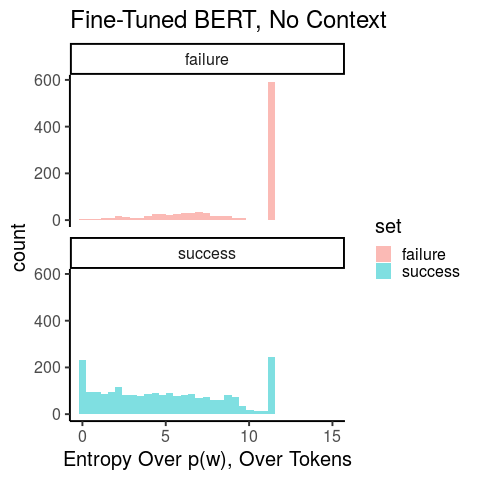

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



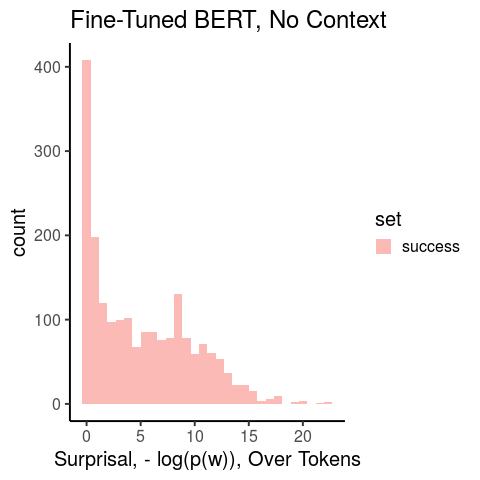

[1] 5.061771


R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



In [1292]:
plot_entropies(ft1_no_context,'Fine-Tuned BERT, No Context','ftb_nocontext')

In [1266]:
adult_no_context = transfomers_bert_completions.compare_successes_failures(all_tokens,
    success_utts, yyy_utts, adult_bertMaskedLM, adult_tokenizer,
    adult_softmax_mask, 1000, None, use_speaker_labels=False)

Computing failure scores
Computing success scores


/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



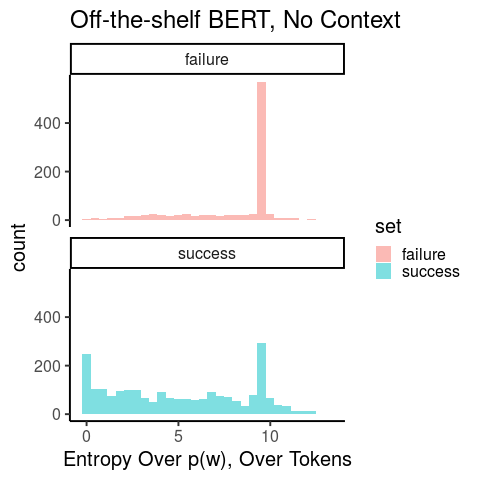

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



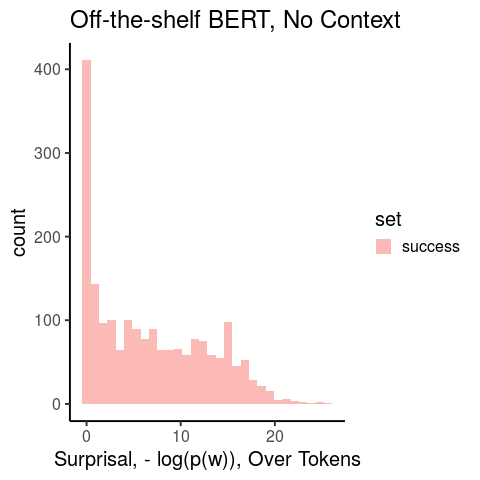

[1] 6.718798


R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



In [1267]:
plot_entropies(adult_no_context,'Off-the-shelf BERT, No Context','otsb_nocontext')

In [1268]:
ft2_no_context = transfomers_bert_completions.compare_successes_failures(all_tokens,
    success_utts, yyy_utts, ft2_bertMaskedLM, ft2_tokenizer,
    ft2_softmax_mask, 1000, None, use_speaker_labels=False)

Computing failure scores
Computing success scores


/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



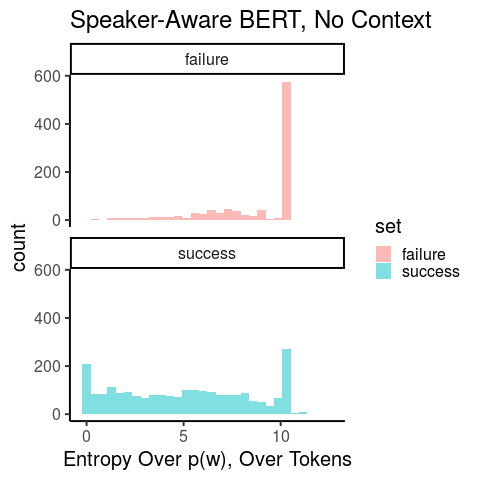

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



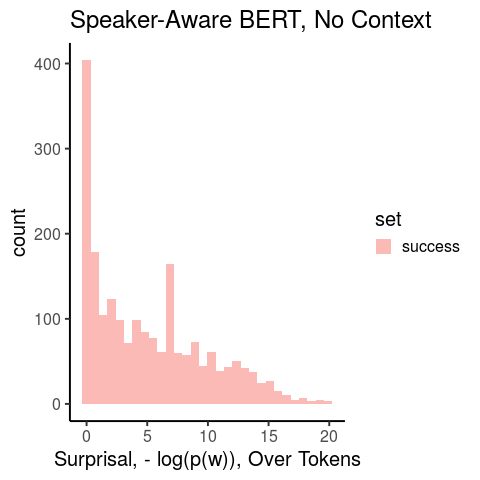

[1] 5.13809


R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



In [1269]:
plot_entropies(ft2_no_context,'Speaker-Aware BERT, No Context',
               'ftb2_nocontext')

Need to look more into the tokenization for the Speaker-aware model

In [1271]:
adult_5context = transfomers_bert_completions.compare_successes_failures(all_tokens,
    success_utts, yyy_utts, adult_bertMaskedLM, adult_tokenizer,
    adult_softmax_mask, 1000, 5, use_speaker_labels=False)

Computing failure scores
Computing success scores


R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



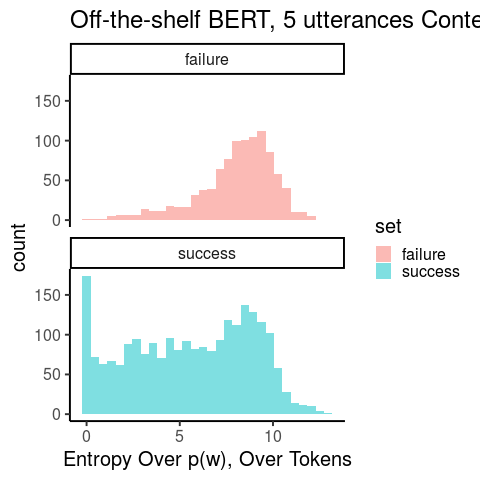

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



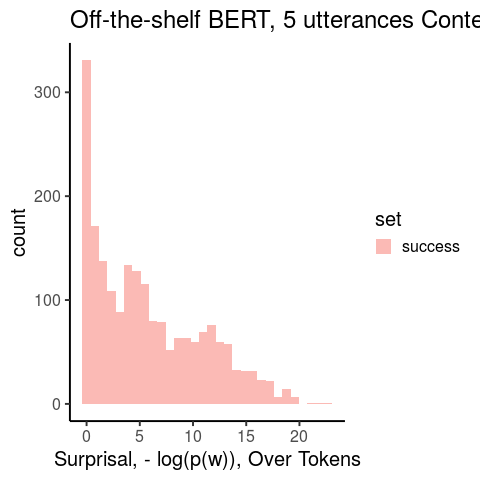

[1] 5.774021


R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



In [1275]:
plot_entropies(adult_5context,'Off-the-shelf BERT, 5 utterances Context',
               'otsb_5uttscontext')

In [1276]:
ft1_5context = transfomers_bert_completions.compare_successes_failures(all_tokens,
    success_utts, yyy_utts, ft1_bertMaskedLM, ft1_tokenizer,
    ft1_softmax_mask, 1000, 5, use_speaker_labels=False)

Computing failure scores
Computing success scores


/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



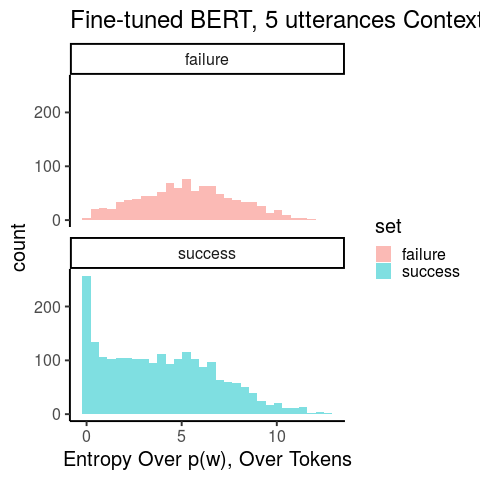

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



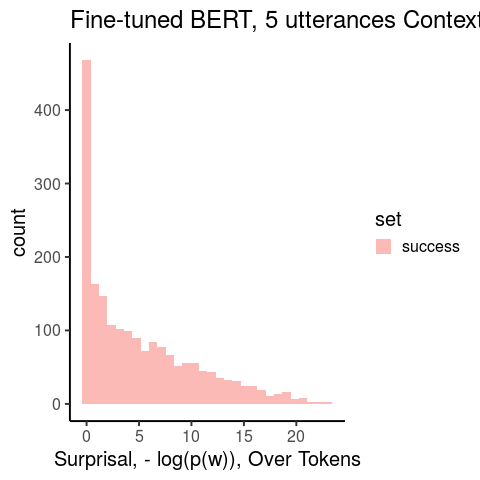

[1] 5.08505


R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



In [1277]:
plot_entropies(ft1_5context,'Fine-tuned BERT, 5 utterances Context',
               'ft1_5uttscontext')

In [1278]:
ft1_20context = transfomers_bert_completions.compare_successes_failures(all_tokens,
    success_utts, yyy_utts, ft1_bertMaskedLM, ft1_tokenizer,
    ft1_softmax_mask, 1000, 20, use_speaker_labels=False)

Computing failure scores
Computing success scores


/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



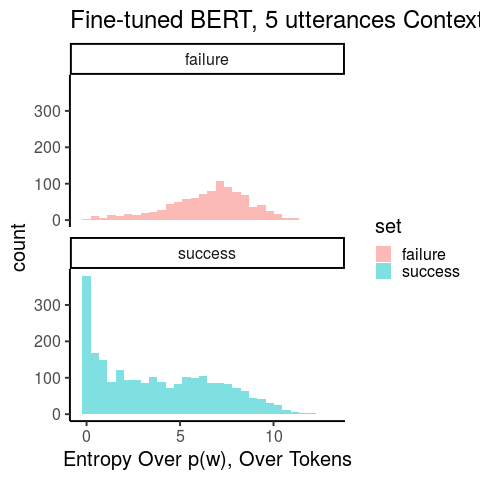

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



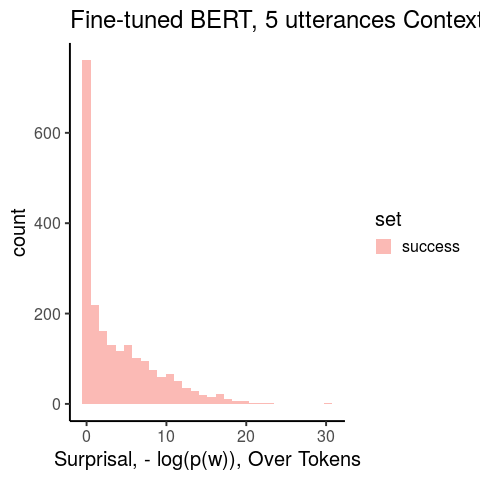

[1] 3.935533


R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



In [1279]:
plot_entropies(ft1_20context,'Fine-tuned BERT, 20 utterances Context',
               'ft1_20uttscontext')

In [ ]:
adult_20context = transfomers_bert_completions.compare_successes_failures(all_tokens,
    success_utts, yyy_utts, adult_bertMaskedLM, adult_tokenizer,
    adult_softmax_mask, 1000, 20, use_speaker_labels=False)

### Unigram Model

In [1286]:
import transfomers_bert_completions
imp.reload(transfomers_bert_completions)
unigram_scores = transfomers_bert_completions.compare_successes_failures_unigram_model(
    all_tokens,
    success_utts,
    yyy_utts,
    adult_tokenizer,
    adult_softmax_mask,
    1000,
    'data/chi_vocab.csv')

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



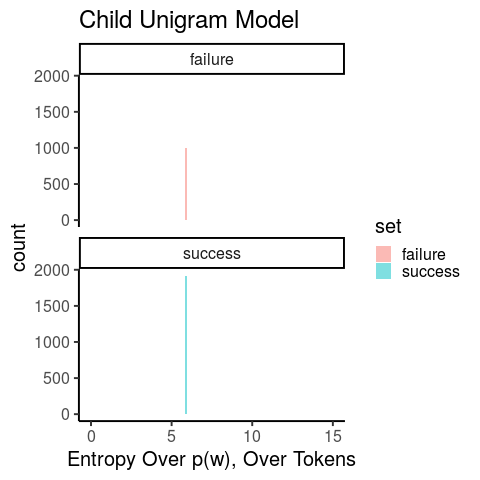

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



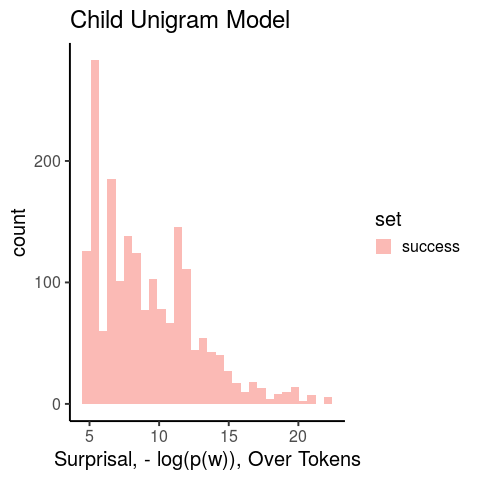

[1] 9.129607


R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



In [1293]:
plot_entropies(unigram_scores,'Child Unigram Model',
               'unigram')

In [ ]:
#[X] compare against model with context
    # [ ] filter can be run after retrieving the scores
#[ ] need some code for the dummy unigram model
#[ ] exclusions on this list -- weird things like apostrophes. Note that this 
#[ ] Get the best performing model running on a large sample of utterances
    # [X] give compare_successes_failures an option to run everything

In [1284]:
unigram_scores

,token,Unnamed: 0,word,count,prob,entropy,set,0
0,hi,193.0,hi,3266.0,0.000795,5.943078,success,NaN
1,hi,193.0,hi,3266.0,0.000795,5.943078,success,NaN
2,dirty,449.0,dirty,1239.0,0.000301,5.943078,success,NaN
3,dirty,449.0,dirty,1239.0,0.000301,5.943078,success,NaN
4,shirt,584.0,shirt,891.0,0.000217,5.943078,success,NaN
...,...,...,...,...,...,...,...,...
995,NaN,NaN,NaN,NaN,NaN,NaN,failure,5.943078
996,NaN,NaN,NaN,NaN,NaN,NaN,failure,5.943078
997,NaN,NaN,NaN,NaN,NaN,NaN,failure,5.943078
998,NaN,NaN,NaN,NaN,NaN,NaN,failure,5.943078


####  Run all on best performing model

In [1315]:
%load_ext line_profiler
%lprun -u 1 -f transfomers_bert_completions.bert_completions transfomers_bert_completions.compare_successes_failures(all_tokens, \
    success_utts, yyy_utts, ft1_bertMaskedLM, ft1_tokenizer, \
    ft1_softmax_mask, 20, 20, use_speaker_labels=False)

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
Computing failure scores
Computing success scores


In [1297]:
alltokens_ft1_20context

/home/stephan/notebooks/child-directed-listening/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,rank,prob,entropy,num_tokens_in_context,set,mask_position,token,utterance_id
0,NaN,NaN,6.241321,193,failure,NaN,NaN,NaN
0,180.0,0.000142,5.565594,330,success,0.0,sit,17012311.0


In [ ]:
# profiling 20 iterations in get_stats_for_success takes 22 seconds
# 2 for before/after_by_sent_df = pd.concat(before/after_by_sent)
# 16s for get_completions_for_mask()
# 28.9s for  get_completions_for_mask, 29.4 from bert_completions
# 22.54s for bert_completions, 17 fom predictions, 4.4 from generating the utterances
# [ ] is there a way to batch this?
# batching looks hard because torch.tensor([indexed_tokens]) would be various lengths

In [1319]:
import transfomers_bert_completions
imp.reload(transfomers_bert_completions)
transfomers_bert_completions.compare_successes_failures(all_tokens, \
    success_utts, yyy_utts, ft1_bertMaskedLM, ft1_tokenizer, \
    ft1_softmax_mask, 20, 20, use_speaker_labels=False)

Computing failure scores


KeyboardInterrupt: 

# How much of the CDI is on the BERT vocab 

In [ ]:
# check if ws/wg words are in the BERT vocab
# this can be a separate analysis as the other one is running 

In [ ]:
Good news: 
- 270k communicative success tokens, 30k communicative failure tokens BEFORE monosyllabic filter 
- error prevalence plummets over time ; very clean in the Providence data

Bad news: 
- A lot of the IPA is narrow phonetic transcription (eg aspiration). This means 
    it isn't easy to compute its likelikhood using the PFST.
        [ ] Is there a way to remap from narrow to broad phonology?
        [ ] Could throw away some of the data for long tail of phonology
        -- This looks like it is cleaner in Providence alone 
- PFST treatment of diphthongs is going to be a challenge
- No syllable information in the phonemic transcripts
    This is made harder by the narrow phonetic transcription -- CV pattern detector
     needs to handle narrow phonology rather than broad phonology
- Weird estimates for non-
        
Observations:
"dʌɡə": depends on whether there is a dog in the context. Definitely need the model to be able to use 
    condition on recent words in the context (eg dog by the adult productions)
    
    
